In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import scipy
import os
from scipy.stats import linregress
from datetime import timedelta

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

## 1. Load in Files and Set Up

In [3]:
fielddata_path = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/field_data/LWC_LFM_WP_dates20230525.csv'
cwc_data_dir = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300'

In [4]:
fielddata = pd.read_csv(fielddata_path)

lwp = fielddata[['tree','time','species','date_wp','mpa_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwp['datetime_wp'] = lwp.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)
lwp['mpa_mean'] = lwp['mpa_mean']*-1

lwa = fielddata[['tree','time','species','date_wp','lwa_g_cm2']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwa['datetime_wp'] = lwa.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

lwc = fielddata[['tree','time','species','date_wp','lwc_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwc['datetime_wp'] = lwc.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

In [5]:
## Loading in CWC data...

# full_date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
date_list = ['20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
datetime_list = [datetime.strptime(date, '%Y%m%d') for date in date_list]

# handling for non-convergence in the invert_liquid_water function
def kill_nans(df):
    mask = (df['CWC'] > 0.499962 - 0.0001) & (df['CWC'] < 0.499962 + 0.0001) # dumb floating point bullshit
    df.loc[mask, 'CWC'] = np.nan
    return df

cwc_file_paths = [os.path.join(cwc_data_dir, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc = pd.read_csv(cwc_file_paths[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc = cwc.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list = []
for date, file_path in zip(date_list, cwc_file_paths):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list.append(cwc_df)

## 2. Joining CWC and Field Data

In [6]:
## function to hunt down the MD LWP for a given tree and date
def get_midday_lwp(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN # specific handling for uncertainty in tree number (whoops)
    lowerDateBound = imgdate + timedelta(days=-3)
    upperDateBound = imgdate + timedelta(days=3)
    filtered = lwp[(lwp['tree']==int(thisTree)) & (lwp['time']=='md') & (lwp['datetime_wp']<=upperDateBound) & (lwp['datetime_wp']>=lowerDateBound)]
    return filtered['mpa_mean'].mean()

## function to hunt down the PD LWP for a given tree and date
def get_predawn_lwp(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN
    lowerDateBound = imgdate + timedelta(days=-8)
    upperDateBound = imgdate + timedelta(days=8)
    filtered = lwp[(lwp['tree']==int(thisTree)) & (lwp['time']=='pd') & (lwp['datetime_wp']<=upperDateBound) & (lwp['datetime_wp']>=lowerDateBound)]
    return filtered['mpa_mean'].mean()

## function to hunt down the MD LWC for a given tree and date
def get_midday_lwc(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN
    lowerDateBound = imgdate + timedelta(days=-3)
    upperDateBound = imgdate + timedelta(days=3)
    filtered = lwc[(lwc['tree']==int(thisTree)) & (lwc['time']=='md') & (lwc['datetime_wp']<=upperDateBound) & (lwc['datetime_wp']>=lowerDateBound)]
    return filtered['lwc_mean'].mean()

In [7]:
## append the LWP and LWC data to the CWC dataframes
for cwc_df in cwc_df_list:
    cwc_df['midday_lwp'] = cwc_df.apply(lambda x: get_midday_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['predawn_lwp'] = cwc_df.apply(lambda x: get_predawn_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['midday_lwc'] = cwc_df.apply(lambda x: get_midday_lwc(x['Tree Number'], x['datetime']), axis=1)


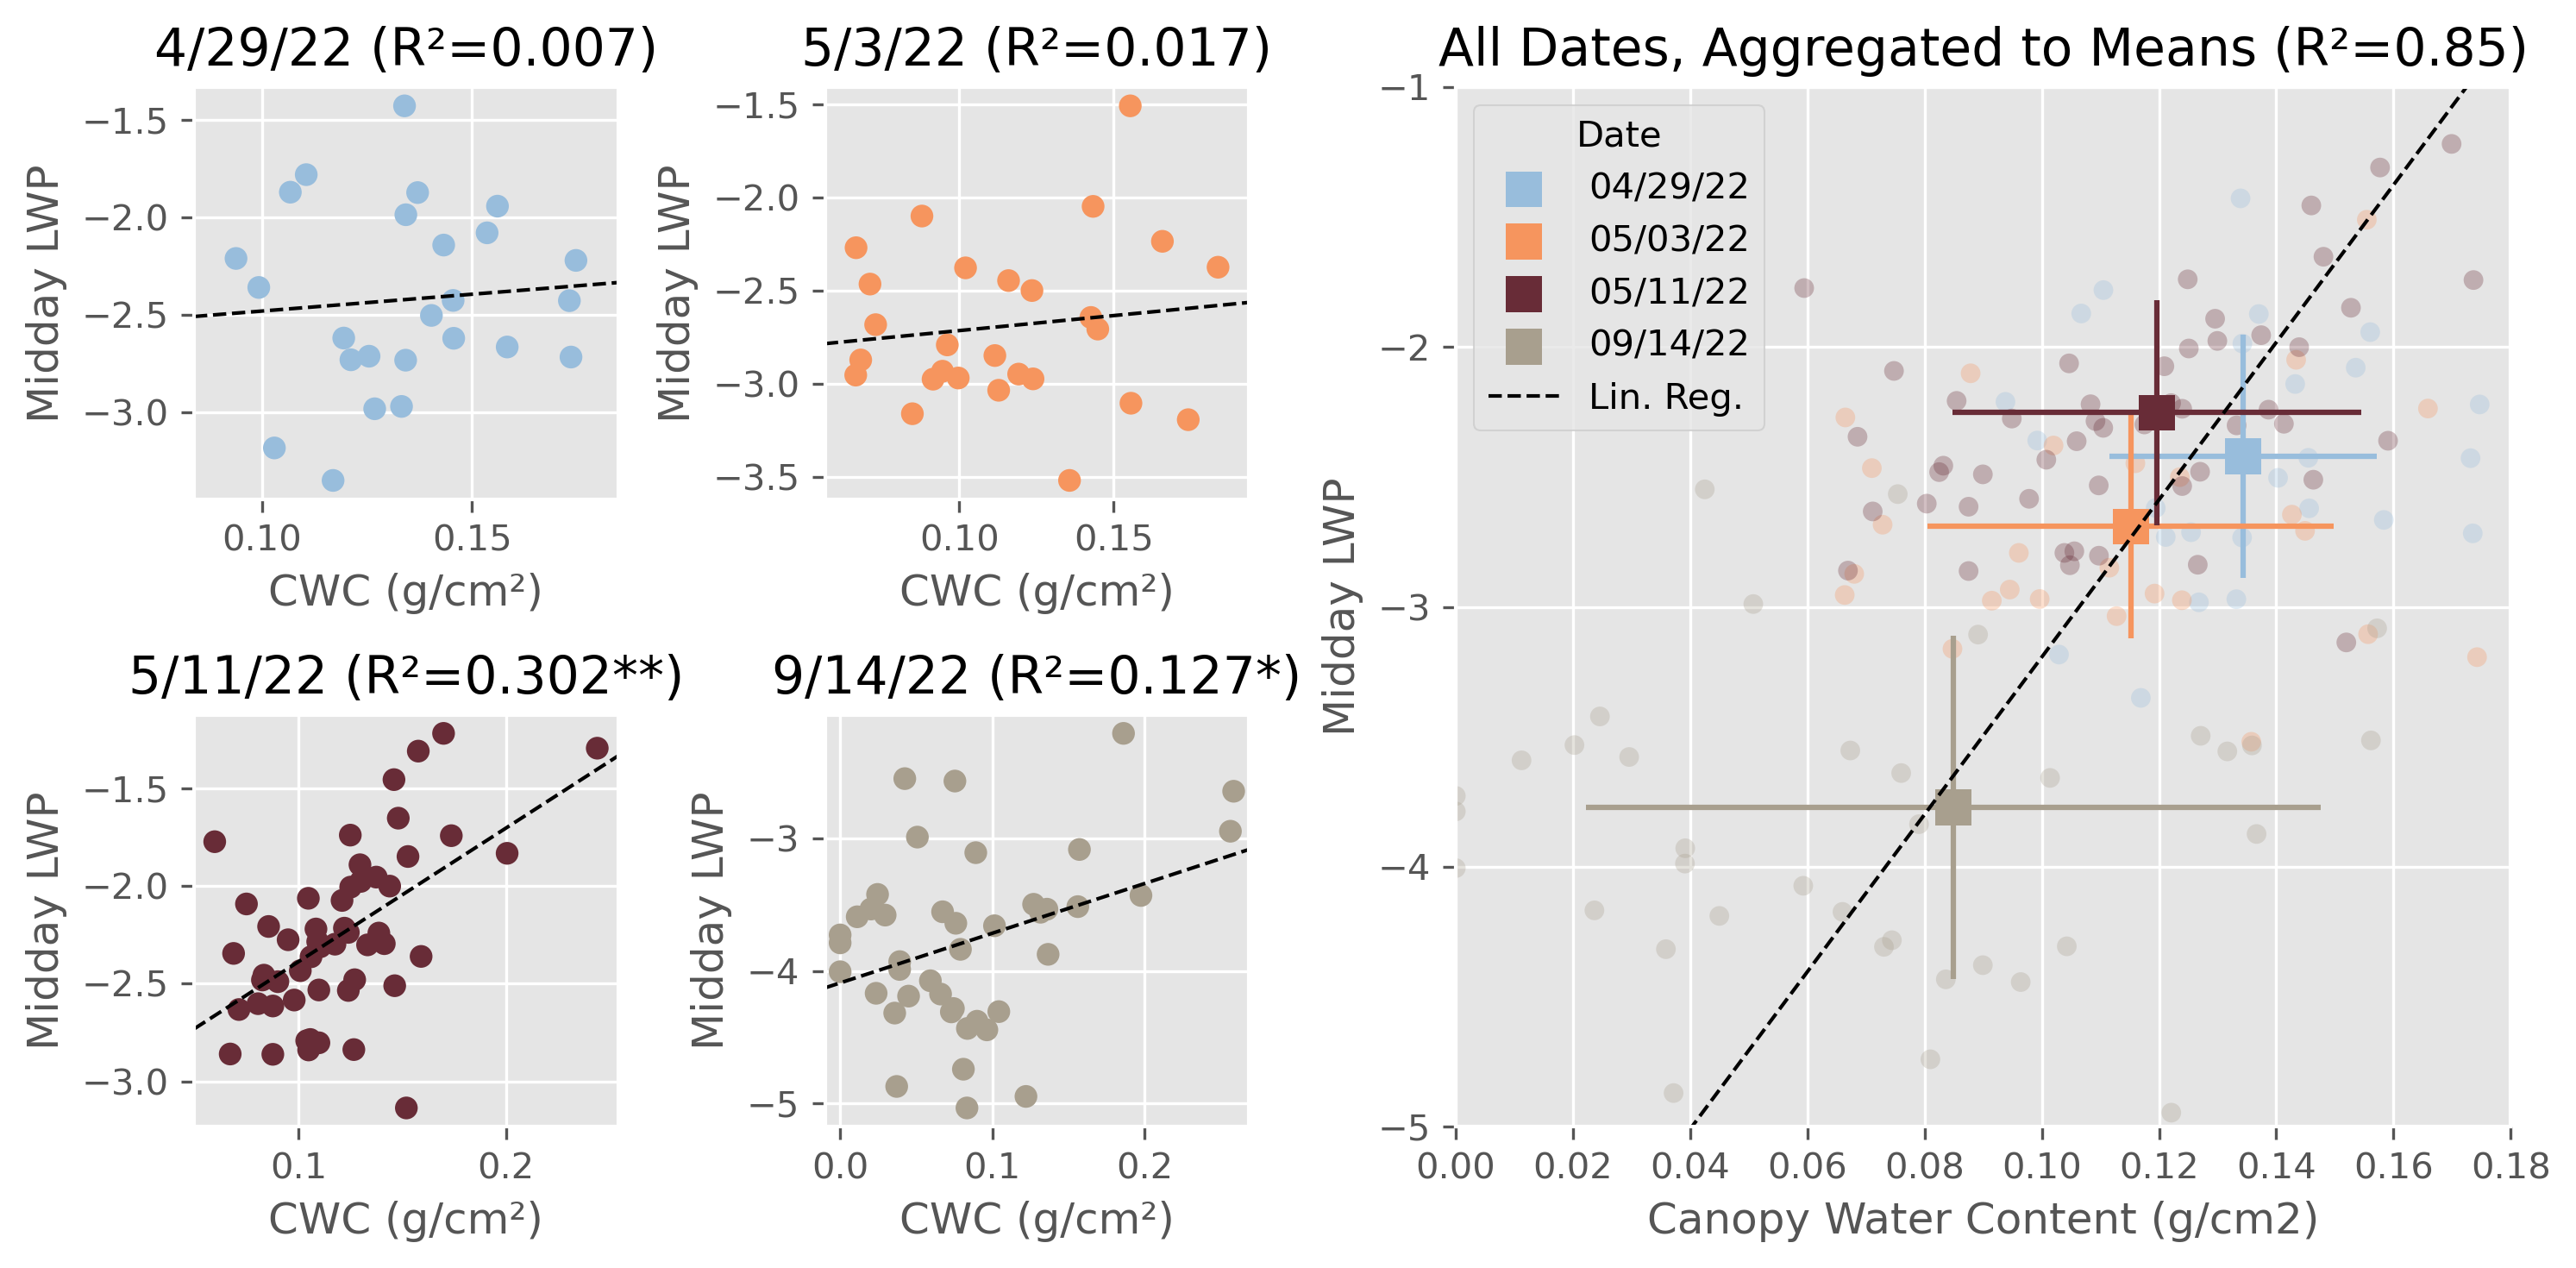

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

# Defining color cycle to correspond with dates, extended a lil to account for more dates
color_list = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#A89F8EFF", "#9B6981FF", "#7887A4FF"] # Arches

# merge right half of axs
gs = axs[0, 2].get_gridspec()
axs[0, 2].remove()  # remove the dead subplots
axs[0, 3].remove()
axs[1, 2].remove()
axs[1, 3].remove()
axbig = fig.add_subplot(gs[0:2, 2:]) # add a big one

# plot CWC vs LWP for 4/29
cwc_df_0429 = cwc_df_list[0]
axs[0,0].scatter(cwc_df_0429['CWC'], cwc_df_0429['midday_lwp'], edgecolors='none', s=40, c=color_list[0])
# regression
good_stuff_lwp = cwc_df_0429[['CWC', 'midday_lwp']].dropna()
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(good_stuff_lwp['CWC'], good_stuff_lwp['midday_lwp'])
cwc_min = good_stuff_lwp['CWC'].min()-0.01
cwc_max = good_stuff_lwp['CWC'].max()+0.01
cwc_range = np.linspace(cwc_min, cwc_max, 100)
r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'
axs[0,0].plot(cwc_range, intercept_lwp + slope_lwp*cwc_range, 'black', label='fitted line', linewidth=1, linestyle='--')
axs[0,0].set_title('4/29/22 ('+r2_str+')')
axs[0,0].set_ylabel('Midday LWP')
axs[0,0].set_xlabel('CWC (g/cm²)')
axs[0,0].set_xlim(cwc_min, cwc_max)

# plot CWC vs LWP for 5/3
cwc_df_0503 = cwc_df_list[1]
axs[0,1].scatter(cwc_df_0503['CWC'], cwc_df_0503['midday_lwp'], edgecolors='none', s=40, c=color_list[1])
# regression
good_stuff_lwp = cwc_df_0503[['CWC', 'midday_lwp']].dropna()
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(good_stuff_lwp['CWC'], good_stuff_lwp['midday_lwp'])
cwc_min = good_stuff_lwp['CWC'].min()-0.01
cwc_max = good_stuff_lwp['CWC'].max()+0.01
cwc_range = np.linspace(cwc_min, cwc_max, 100)
r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'
axs[0,1].plot(cwc_range, intercept_lwp + slope_lwp*cwc_range, 'black', label='fitted line', linewidth=1, linestyle='--')
axs[0,1].set_title('5/3/22 ('+r2_str+')')
axs[0,1].set_ylabel('Midday LWP')
axs[0,1].set_xlabel('CWC (g/cm²)')
axs[0,1].set_xlim(cwc_min, cwc_max)

# plot CWC vs LWP for 5/11
cwc_df_0511 = cwc_df_list[2]
axs[1,0].scatter(cwc_df_0511['CWC'], cwc_df_0511['midday_lwp'], edgecolors='none', s=40, c=color_list[2])
# regression
good_stuff_lwp = cwc_df_0511[['CWC', 'midday_lwp']].dropna()
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(good_stuff_lwp['CWC'], good_stuff_lwp['midday_lwp'])
cwc_min = good_stuff_lwp['CWC'].min()-0.01
cwc_max = good_stuff_lwp['CWC'].max()+0.01
cwc_range = np.linspace(cwc_min, cwc_max, 100)
r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'
axs[1,0].plot(cwc_range, intercept_lwp + slope_lwp*cwc_range, 'black', label='fitted line', linewidth=1, linestyle='--')
axs[1,0].set_title('5/11/22 ('+r2_str+')')
axs[1,0].set_ylabel('Midday LWP')
axs[1,0].set_xlabel('CWC (g/cm²)')
axs[1,0].set_xlim(cwc_min, cwc_max)

# plot CWC vs LWP for 9/14
cwc_df_0914 = cwc_df_list[-1]
axs[1,1].scatter(cwc_df_0914['CWC'], cwc_df_0914['midday_lwp'], edgecolors='none', s=40, c=color_list[3])
# regression
good_stuff_lwp = cwc_df_0914[['CWC', 'midday_lwp']].dropna()
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(good_stuff_lwp['CWC'], good_stuff_lwp['midday_lwp'])
cwc_min = good_stuff_lwp['CWC'].min()-0.01
cwc_max = good_stuff_lwp['CWC'].max()+0.01
cwc_range = np.linspace(cwc_min, cwc_max, 100)
r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'
axs[1,1].plot(cwc_range, intercept_lwp + slope_lwp*cwc_range, 'black', label='fitted line', linewidth=1, linestyle='--')
axs[1,1].set_title('9/14/22 ('+r2_str+')')
axs[1,1].set_ylabel('Midday LWP')
axs[1,1].set_xlabel('CWC (g/cm²)')
axs[1,1].set_xlim(cwc_min, cwc_max)

avg_cwcs = []
avg_midday_lwps = []
color_list = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#9B6981FF", "#7887A4FF", "#A89F8EFF"] # Arches
for date, cwc_df, color in zip(date_list, cwc_df_list, color_list):
        # format date to "MM-DD-YY"
        date = datetime.strptime(date, '%Y%m%d').strftime('%m/%d/%y')

        cwc_df_dropna_lwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
        avg_cwc_lwp = cwc_df_dropna_lwp['CWC'].mean()
        avg_cwcs.append(avg_cwc_lwp)
        avg_midday_lwp = cwc_df_dropna_lwp['midday_lwp'].mean()
        avg_midday_lwps.append(avg_midday_lwp)
        std_cwc_lwp = cwc_df_dropna_lwp['CWC'].std()
        std_midday_lwp = cwc_df_dropna_lwp['midday_lwp'].std()
        if len(cwc_df_dropna_lwp) == 0:
            continue
    
        axbig.scatter(cwc_df['CWC'], cwc_df['midday_lwp'], c=color, edgecolors='none', s=30, alpha=0.3)
        axbig.scatter(avg_cwc_lwp, avg_midday_lwp, c=color, edgecolors='none', s=100, alpha=1, marker='s', label=date)
        axbig.errorbar(avg_cwc_lwp, avg_midday_lwp, yerr=std_midday_lwp, fmt='none', ecolor=color)
        axbig.errorbar(avg_cwc_lwp, avg_midday_lwp, xerr=std_cwc_lwp, fmt='none', ecolor=color)


# regress mean CWC vs mean LWP
mask = ~np.isnan(avg_cwcs) & ~np.isnan(avg_midday_lwps)
avg_cwcs = np.array(avg_cwcs)[mask]
avg_midday_lwps = np.array(avg_midday_lwps)[mask]
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(np.array(avg_cwcs), np.array(avg_midday_lwps))
axbig.plot([0,0.18], intercept_lwp + slope_lwp*np.array([0,0.18]), 'black', label='Lin. Reg.', linewidth=1, linestyle='--')

r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'

axbig.set_ylabel('Midday LWP')
axbig.set_xlabel('Canopy Water Content (g/cm2)')
axbig.set_title('All Dates, Aggregated to Means ('+r2_str+')')
axbig.set_xlim(0, 0.18)
axbig.set_ylim(-5, -1)
# set y ticks to ever 1
axbig.yaxis.set_major_locator(ticker.MultipleLocator(1))
# add legend to axbig
handles, labels = axbig.get_legend_handles_labels()
axbig.legend(handles, labels, title='Date', loc='upper left')

plt.tight_layout()
# plt.savefig('CWC_vs_MDLWP.png')
plt.show()

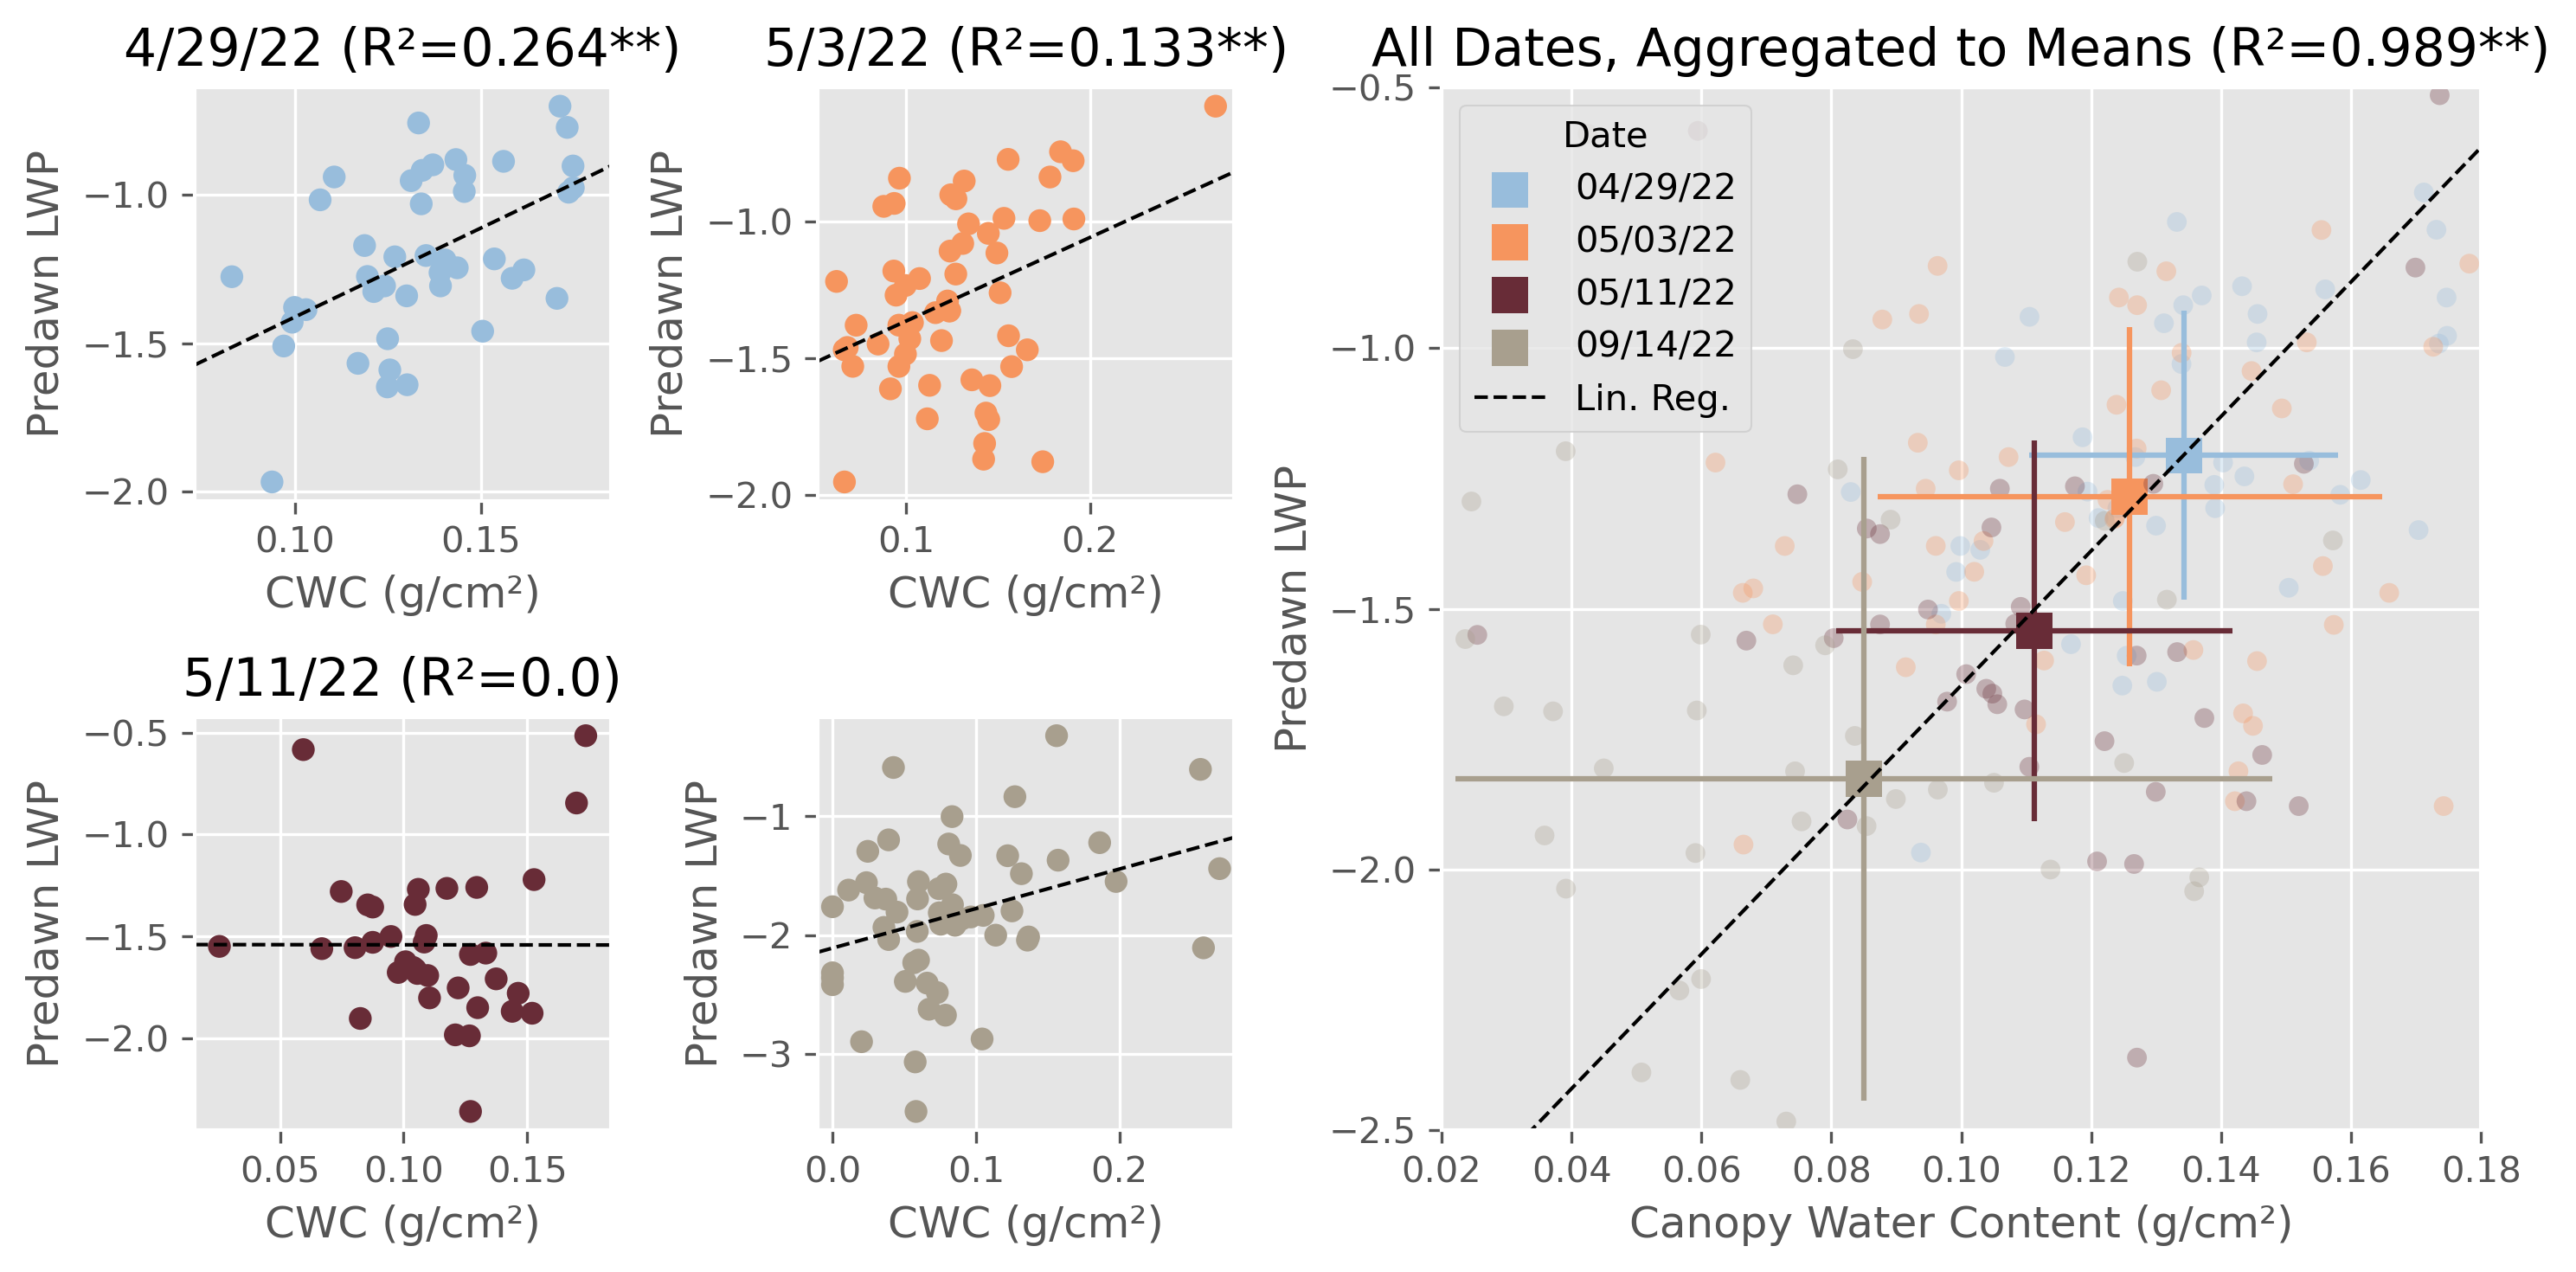

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

# Defining color cycle to correspond with dates, extended a lil to account for more dates
color_list = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#A89F8EFF", "#9B6981FF", "#7887A4FF"] # Arches

# merge right half of axs
gs = axs[0, 2].get_gridspec()
axs[0, 2].remove()  # remove the dead subplots
axs[0, 3].remove()
axs[1, 2].remove()
axs[1, 3].remove()
axbig = fig.add_subplot(gs[0:2, 2:]) # add a big one

# plot CWC vs predawn LWP for 4/29
cwc_df_0429 = cwc_df_list[0]
axs[0,0].scatter(cwc_df_0429['CWC'], cwc_df_0429['predawn_lwp'], edgecolors='none', s=40, c=color_list[0])
# regression
good_stuff_lwp = cwc_df_0429[['CWC', 'predawn_lwp']].dropna()
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(good_stuff_lwp['CWC'], good_stuff_lwp['predawn_lwp'])
cwc_min = good_stuff_lwp['CWC'].min()-0.01
cwc_max = good_stuff_lwp['CWC'].max()+0.01
cwc_range = np.linspace(cwc_min, cwc_max, 100)
r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'
axs[0,0].plot(cwc_range, intercept_lwp + slope_lwp*cwc_range, 'black', label='fitted line', linewidth=1, linestyle='--')
axs[0,0].set_title('4/29/22 ('+r2_str+')')
axs[0,0].set_ylabel('Predawn LWP')
axs[0,0].set_xlabel('CWC (g/cm²)')
axs[0,0].set_xlim(cwc_min, cwc_max)

# plot CWC vs predawn LWP for 5/3
cwc_df_0503 = cwc_df_list[1]
axs[0,1].scatter(cwc_df_0503['CWC'], cwc_df_0503['predawn_lwp'], edgecolors='none', s=40, c=color_list[1])
# regression
good_stuff_lwp = cwc_df_0503[['CWC', 'predawn_lwp']].dropna()
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(good_stuff_lwp['CWC'], good_stuff_lwp['predawn_lwp'])
cwc_min = good_stuff_lwp['CWC'].min()-0.01
cwc_max = good_stuff_lwp['CWC'].max()+0.01
cwc_range = np.linspace(cwc_min, cwc_max, 100)
r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'
axs[0,1].plot(cwc_range, intercept_lwp + slope_lwp*cwc_range, 'black', label='fitted line', linewidth=1, linestyle='--')
axs[0,1].set_title('5/3/22 ('+r2_str+')')
axs[0,1].set_ylabel('Predawn LWP')
axs[0,1].set_xlabel('CWC (g/cm²)')
axs[0,1].set_xlim(cwc_min, cwc_max)

# plot CWC vs predawn LWP for 5/11
cwc_df_0511 = cwc_df_list[2]
axs[1,0].scatter(cwc_df_0511['CWC'], cwc_df_0511['predawn_lwp'], edgecolors='none', s=40, c=color_list[2])
# regression
good_stuff_lwp = cwc_df_0511[['CWC', 'predawn_lwp']].dropna()
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(good_stuff_lwp['CWC'], good_stuff_lwp['predawn_lwp'])
cwc_min = good_stuff_lwp['CWC'].min()-0.01
cwc_max = good_stuff_lwp['CWC'].max()+0.01
cwc_range = np.linspace(cwc_min, cwc_max, 100)
r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'
axs[1,0].plot(cwc_range, intercept_lwp + slope_lwp*cwc_range, 'black', label='fitted line', linewidth=1, linestyle='--')
axs[1,0].set_title('5/11/22 ('+r2_str+')')
axs[1,0].set_ylabel('Predawn LWP')
axs[1,0].set_xlabel('CWC (g/cm²)')
axs[1,0].set_xlim(cwc_min, cwc_max)

# plot CWC vs predawn LWP for 9/14
cwc_df_0914 = cwc_df_list[-1]
axs[1,1].scatter(cwc_df_0914['CWC'], cwc_df_0914['predawn_lwp'], edgecolors='none', s=40, c=color_list[3])
# regression
good_stuff_lwp = cwc_df_0914[['CWC', 'predawn_lwp']].dropna()
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(good_stuff_lwp['CWC'], good_stuff_lwp['predawn_lwp'])
cwc_min = good_stuff_lwp['CWC'].min()-0.01
cwc_max = good_stuff_lwp['CWC'].max()+0.01
cwc_range = np.linspace(cwc_min, cwc_max, 100)
r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'
axs[1,1].plot(cwc_range, intercept_lwp + slope_lwp*cwc_range, 'black', label='fitted line', linewidth=1, linestyle='--')
# axs[1,1].set_title('9/14/22 ('+r2_str+')')
axs[1,1].set_ylabel('Predawn LWP')
axs[1,1].set_xlabel('CWC (g/cm²)')
axs[1,1].set_xlim(cwc_min, cwc_max)

avg_cwcs = []
avg_predawn_lwps = []
color_list = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#9B6981FF", "#7887A4FF", "#A89F8EFF"] # Arches
for date, cwc_df, color in zip(date_list, cwc_df_list, color_list):
        # removing these dates for clarity in the final paper...
        # ... they don't really offer any new information but they do make things more confusing
        if date == '20220517':
            continue
        if date == '20220529':
            continue

        # format date to "MM-DD-YY"
        date = datetime.strptime(date, '%Y%m%d').strftime('%m/%d/%y')

        cwc_df_dropna_lwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
        avg_cwc_lwp = cwc_df_dropna_lwp['CWC'].mean()
        avg_cwcs.append(avg_cwc_lwp)
        avg_predawn_lwp = cwc_df_dropna_lwp['predawn_lwp'].mean()
        avg_predawn_lwps.append(avg_predawn_lwp)
        std_cwc_lwp = cwc_df_dropna_lwp['CWC'].std()
        std_predawn_lwp = cwc_df_dropna_lwp['predawn_lwp'].std()
        if len(cwc_df_dropna_lwp) == 0:
            continue
    
        axbig.scatter(cwc_df['CWC'], cwc_df['predawn_lwp'], c=color, edgecolors='none', s=30, alpha=0.3)
        axbig.scatter(avg_cwc_lwp, avg_predawn_lwp, c=color, edgecolors='none', s=100, alpha=1, marker='s', label=date)
        axbig.errorbar(avg_cwc_lwp, avg_predawn_lwp, yerr=std_predawn_lwp, fmt='none', ecolor=color)
        axbig.errorbar(avg_cwc_lwp, avg_predawn_lwp, xerr=std_cwc_lwp, fmt='none', ecolor=color)


# regress mean CWC vs mean predawn LWP
mask = ~np.isnan(avg_cwcs) & ~np.isnan(avg_predawn_lwps)
avg_cwcs = np.array(avg_cwcs)[mask]
avg_predawn_lwps = np.array(avg_predawn_lwps)[mask]
slope_lwp, intercept_lwp, r_value_lwp, p_value_lwp, std_err_lwp = linregress(np.array(avg_cwcs), np.array(avg_predawn_lwps))
axbig.plot([0,0.18], intercept_lwp + slope_lwp*np.array([0,0.18]), 'black', label='Lin. Reg.', linewidth=1, linestyle='--')

r2_str = 'R²='+str(np.round(r_value_lwp**2, 3))
if p_value_lwp < 0.05:
    r2_str += '*'
if p_value_lwp < 0.01:
    r2_str += '*'

axbig.set_ylabel('Predawn LWP')
axbig.set_xlabel('Canopy Water Content (g/cm²)')
axbig.set_title('All Dates, Aggregated to Means ('+r2_str+')')
axbig.set_xlim(0.02, 0.18)
axbig.set_ylim(-2.5, -0.5)
# set y ticks to every 0.5
axbig.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
# add legend to axbig
handles, labels = axbig.get_legend_handles_labels()
axbig.legend(handles, labels, title='Date', loc='upper left')

plt.tight_layout()
# plt.savefig('CWC_vs_PDLWP_2.png')
plt.show()